compare motif hotspots with signal sequences from transcripts

first translate the occlusion motif from each transcript into peptide sequence
first find the overlapping transcripts between transcripts with big hotspots and transcripts with signal sequences from uniprot
find the similarity score between each motif vs. signal sequence
find the similarity score bewteen each motif vs. randomly selected sequence with same length from the same transcript

In [5]:
import pandas as pd
import csv

In [6]:
#load the genes with signal sequence from Uniprot
#file containing the signal sequence: 
df=pd.read_table('/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/uniprotkb_keyword_KW_0732_AND_reviewed_2024_10_21w_signalP.tsv')
print (df)
signal_seq_genes=df['Gene Names'].tolist()
print (len(signal_seq_genes))
signal_seq_genes=[x for x in signal_seq_genes if pd.notna(x)]
signal_seq_genes=[str(x) for x in signal_seq_genes]

def split_gene_names(gene_list):
    # Split each item by spaces and flatten the resulting list
    split_genes = [gene.strip() for item in gene_list for gene in item.split()]
    
    # Remove any empty strings that might result from extra spaces
    split_genes = [gene for gene in split_genes if gene]
    
    return split_genes


# Create the new list
cleaned_signal_seq_genes = split_gene_names(signal_seq_genes)

# Print the result
print(len(cleaned_signal_seq_genes))


           Entry  Reviewed   Entry Name  \
0     A0A0K2S4Q6  reviewed  CD3CH_HUMAN   
1     A0A1B0GTW7  reviewed  CIROP_HUMAN   
2         A1E959  reviewed   ODAM_HUMAN   
3         A1KZ92  reviewed  PXDNL_HUMAN   
4         A1L4H1  reviewed  SRCRL_HUMAN   
...          ...       ...          ...   
3597      Q6UY13  reviewed  YB003_HUMAN   
3598      Q6ZRU5  reviewed  YQ032_HUMAN   
3599      Q8TAT8  reviewed  YK045_HUMAN   
3600      Q8WWF1  reviewed  CA054_HUMAN   
3601      Q9P1C3  reviewed  YN010_HUMAN   

                                          Protein names  \
0     Protein CD300H (CD300 antigen-like family memb...   
1     Ciliated left-right organizer metallopeptidase...   
2      Odontogenic ameloblast-associated protein (Apin)   
3     Probable oxidoreductase PXDNL (EC 1.-.-.-) (Ca...   
4     Soluble scavenger receptor cysteine-rich domai...   
...                                                 ...   
3597  Putative uncharacterized protein UNQ5830/PRO19...   
3598       

In [7]:
#load the file with hotspot in lowercase so that the hotspots can be translated into peptides
mutation_file='/tscc/nfs/home/bay001/projects/karen_synapse_20240529/permanent_data/04_codon_mutation/outputs/human_30nt_mutated_hotspot_sequences_seed_3.fa'
from Bio import SeqIO

def read_fasta(file_path):
    sequences = {}
    for record in SeqIO.parse(file_path, "fasta"):
        sequences[record.id] = str(record.seq)
    return sequences

# Usage

fasta_sequences = read_fasta(mutation_file)
print (len(fasta_sequences))


2732


In [10]:
#for each entry in the mutation file, add gene symbol to each entry, and then translate the lowercase motif into peptide

import pandas as pd
from biomart import BiomartServer
from Bio import SeqIO
from Bio.Seq import Seq
import re
import time

def map_transcripts_to_genes(df, batch_size=100):
    # Connect to Ensembl BioMart
    server = BiomartServer("http://www.ensembl.org/biomart")
    dataset = server.datasets['hsapiens_gene_ensembl']
    
    # Get the unique transcript IDs
    transcript_ids = df['transcript_id'].unique().tolist()
    
    # Initialize an empty dictionary to store the mapping
    mapping = {}
    
    # Process in batches
    for i in range(0, len(transcript_ids), batch_size):
        batch = transcript_ids[i:i+batch_size]
        
        # Prepare the query
        response = dataset.search({
            'attributes': ['ensembl_transcript_id', 'external_gene_name'],
            'filters': {'ensembl_transcript_id': batch}
        })
        
        # Update the mapping dictionary
        for line in response.iter_lines():
            transcript, gene = line.decode().split('\t')
            mapping[transcript] = gene
        
        print(f"Processed {i+len(batch)}/{len(transcript_ids)} transcripts")
        time.sleep(1)  # Add a small delay to avoid overwhelming the server
    
    # Add gene symbols to the DataFrame
    df['gene_symbol'] = df['transcript_id'].map(mapping)
    return df

def translate_lowercase_to_protein(input_file, output_file):
    # Read FASTA file and create a DataFrame
    records = list(SeqIO.parse(input_file, "fasta"))
    df = pd.DataFrame({'transcript_id': [record.id for record in records],
                       'sequence': [str(record.seq) for record in records]})
    
    # Map transcripts to genes
    df = map_transcripts_to_genes(df)
    
    with open(output_file, 'w') as out_f:
        for _, row in df.iterrows():
            sequence = row['sequence']
            transcript_name = row['transcript_id']
            gene_symbol = row['gene_symbol'] if pd.notna(row['gene_symbol']) else "Unknown"
            
            # Find all lowercase subsequences
            lowercase_matches = re.finditer(r'[a-z]+', sequence)
            
            for i, match in enumerate(lowercase_matches, 1):
                lowercase_seq = match.group()
                
                # Translate the lowercase sequence to protein
                protein_seq = str(Seq(lowercase_seq).translate())
                
                # Write to output file in FASTA format with detailed header
                header = f">{transcript_name}|lower_case_region_{i}|{gene_symbol}"
                out_f.write(f"{header}\n")
                out_f.write(f"{protein_seq}\n")

# Usage
input_file = mutation_file  # Make sure this variable is defined
output_file = '/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_mutated_hotspot_sequences_seed_3_translated_peptide.fa'

translate_lowercase_to_protein(input_file, output_file)
print(f"Translated protein sequences have been saved to {output_file}")

# Optional: Print the first few entries of the output file
print("\nFirst few entries of the output file:")
with open(output_file, 'r') as f:
    for i, line in enumerate(f):
        if i < 3:  # Print first 10 lines
            print(line.strip())
        else:
            break

ParseError: mismatched tag: line 62, column 2 (<string>)

In [11]:
import pandas as pd
from Bio import SeqIO
from Bio import pairwise2
import numpy as np

def parse_uniprot_data(file_path):
    df = pd.read_csv(file_path, sep='\t')
    signal_seq_dict = {}
    for _, row in df.iterrows():
        gene_names = str(row['Gene Names']).split()
        signal_seq = row['signalp_sequence']
        for gene in gene_names:
            signal_seq_dict[gene] = signal_seq
    return signal_seq_dict

def parse_fasta_file(file_path):
    peptide_dict = {}
    for record in SeqIO.parse(file_path, "fasta"):
        transcript_id, _, gene_symbol = record.id.split('|')
        if gene_symbol not in peptide_dict:
            peptide_dict[gene_symbol] = []
        peptide_dict[gene_symbol].append((transcript_id, str(record.seq)))
    return peptide_dict

def local_alignment_score(seq1, seq2):
    alignments = pairwise2.align.localxx(seq1, seq2)
    return alignments[0].score if alignments else 0

def sliding_window_similarity(motif, signal):
    max_similarity = 0
    for i in range(len(signal) - len(motif) + 1):
        window = signal[i:i+len(motif)]
        similarity = sum(a == b for a, b in zip(motif, window)) / len(motif)
        max_similarity = max(max_similarity, similarity)
    return max_similarity

def longest_common_subsequence(seq1, seq2):
    m, n = len(seq1), len(seq2)
    L = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0:
                L[i][j] = 0
            elif seq1[i-1] == seq2[j-1]:
                L[i][j] = L[i-1][j-1] + 1
            else:
                L[i][j] = max(L[i-1][j], L[i][j-1])
    return L[m][n]

def calculate_similarity(seq1, seq2):
    return {
        'Sequence_Identity': sum(a == b for a, b in zip(seq1, seq2)) / max(len(seq1), len(seq2)),
        'Local_Alignment_Score': local_alignment_score(seq1, seq2),
        'Sliding_Window_Similarity': sliding_window_similarity(seq1, seq2),
        'Longest_Common_Subsequence': longest_common_subsequence(seq1, seq2)
    }

def compare_sequences(signal_seq_dict, peptide_dict):
    results = []
    for gene, peptides in peptide_dict.items():
        if gene in signal_seq_dict:
            signal_seq = signal_seq_dict[gene]
            for transcript_id, peptide in peptides:
                similarity_metrics = calculate_similarity(signal_seq, peptide)
                result = {
                    'Transcript_ID': transcript_id,
                    'Gene_Symbol': gene,
                    'Signal_Sequence': signal_seq,
                    'Peptide_Sequence': peptide
                }
                result.update(similarity_metrics)
                results.append(result)
    return pd.DataFrame(results)

# Usage
uniprot_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/uniprotkb_keyword_KW_0732_AND_reviewed_2024_10_21w_signalP.tsv"
fasta_file = '/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_mutated_hotspot_sequences_seed_3_translated_peptide.fa'
signal_seq_dict = parse_uniprot_data(uniprot_file)
peptide_dict = parse_fasta_file(fasta_file)

results_df = compare_sequences(signal_seq_dict, peptide_dict)

# Display results
print(results_df)

# Save results to a CSV file
results_df.to_csv("/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_sequence_signal_peptide_comparison_results.csv", index=False)


/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


        Transcript_ID Gene_Symbol                 Signal_Sequence  \
0     ENST00000698639       IL6ST          MLTLQTWLVQALFIFLTTESTG   
1     ENST00000698639       IL6ST          MLTLQTWLVQALFIFLTTESTG   
2     ENST00000698639       IL6ST          MLTLQTWLVQALFIFLTTESTG   
3     ENST00000698639       IL6ST          MLTLQTWLVQALFIFLTTESTG   
4     ENST00000381298       IL6ST          MLTLQTWLVQALFIFLTTESTG   
...               ...         ...                             ...   
1954  ENST00000393409      PLXNA1      MPLPPRSLQVLLLLLLLLLLLPGMWA   
1955  ENST00000393409      PLXNA1      MPLPPRSLQVLLLLLLLLLLLPGMWA   
1956  ENST00000503771     TMEM158            MLPLLAALLAAACPLPPVRG   
1957  ENST00000503771     TMEM158            MLPLLAALLAAACPLPPVRG   
1958  ENST00000377252      PLXDC2  MARFPKADLAAAGVMLLCHFFTDQFQFADG   

                              Peptide_Sequence  Sequence_Identity  \
0                              LVQALFIFLTTESTG           0.000000   
1     KCMDYFHVNANYIVWKTNHFTIPKEQY

In [12]:
#now for the negative control, we want to randomly select sequences of the same length as the signal sequence from the transcripts; first we need
#to add gene symbolt to the CDS only mutation file


from Bio import SeqIO
import pandas as pd

def parse_translated_peptide_file(file_path):
    transcript_to_gene = {}
    for record in SeqIO.parse(file_path, "fasta"):
        parts = record.id.split('|')
        if len(parts) >= 3:
            transcript_id = parts[0]
            gene_symbol = parts[2]
            transcript_to_gene[transcript_id] = gene_symbol
    return transcript_to_gene

def add_gene_symbols_to_rna_sequences(rna_file_path, transcript_to_gene):
    updated_records = []
    for record in SeqIO.parse(rna_file_path, "fasta"):
        transcript_id = record.id
        if transcript_id in transcript_to_gene:
            gene_symbol = transcript_to_gene[transcript_id]
            record.id = f"{transcript_id}|{gene_symbol}"
            record.description = f"{transcript_id}|{gene_symbol}"
        updated_records.append(record)
    return updated_records

# File paths
translated_peptide_file = '/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_mutated_hotspot_sequences_seed_3_translated_peptide.fa'
rna_sequence_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_30nt_mutated_hotspot_sequences_seed_3.CDS_only.fa"
output_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_codon_mutated_onlyCDS_sequences_with_gene_symbols.fa"

# Parse the translated peptide file to get transcript ID to gene symbol mapping
transcript_to_gene = parse_translated_peptide_file(translated_peptide_file)

# Add gene symbols to RNA sequences
updated_records = add_gene_symbols_to_rna_sequences(rna_sequence_file, transcript_to_gene)

# Write the updated sequences to a new file
with open(output_file, "w") as output_handle:
    SeqIO.write(updated_records, output_handle, "fasta")

print(f"Updated sequences written to {output_file}")

# Optional: Display the first few updated records
for record in updated_records[:5]:
    print(f">{record.id}")
    print(record.seq[:50] + "...")  # Print first 50 bases
    
num_sequences = len(updated_records)
print (num_sequences)

Updated sequences written to /tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_codon_mutated_onlyCDS_sequences_with_gene_symbols.fa
>ENST00000234831|TMEM59
atggccgctccaaaaggatcgctatgggttagaacgcagctaggtcttcc...
>ENST00000439984|PCNX1
ATGGGGTCGCAGACGCTGCAGATCCTCCGACAGGGGGTGTGGGCCGCGCT...
>ENST00000313669|COL26A1
atgaaattagcgttgttgctcccatgggcatgctgttgtCTCTGCGGGTC...
>ENST00000682254|CHRM4
ATGGCCAACTTCACACCTGTCAATGGCAGCTCGGGCAATCAGTCCGTGCG...
>ENST00000396872|SLC29A4
ATGGGCTCCGTGGGGAGCCAGCGCCTTGAGGAGCCCAGCGTGGCAGGCAC...
2853


In [13]:
#translate the cds only file into peptide, then randomly select the sequences of the same length as the signal sequence, then compute the similarity metrics
from Bio import SeqIO
from Bio.Seq import Seq

def translate_fasta(input_file, output_file):
    with open(output_file, 'w') as out_handle:
        for record in SeqIO.parse(input_file, "fasta"):
            # Extract gene symbol from the description
            gene_symbol = record.description.split('|')[1] if '|' in record.description else ''
            
            # Translate the sequence
            protein_seq = str(Seq(str(record.seq)).translate())
            
            # Write the translated sequence to the output file
            out_handle.write(f">{record.id}|{gene_symbol}\n{protein_seq}\n")

# Usage
input_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_codon_mutated_onlyCDS_sequences_with_gene_symbols.fa"
output_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_codon_mutated_onlyCDS_sequence_translated_peptide_sequences.fa"

translate_fasta(input_file, output_file)
print(f"Translated sequences have been written to {output_file}")

sequence_count = len(list(SeqIO.parse(output_file, "fasta")))
print(f"Total number of sequences in the output file: {sequence_count}")

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


Translated sequences have been written to /tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_codon_mutated_onlyCDS_sequence_translated_peptide_sequences.fa
Total number of sequences in the output file: 2853


In [14]:
from Bio import SeqIO
import re

def count_total_lowercase_stretches(input_file):
    total_stretches = 0
    total_sequences = 0

    for record in SeqIO.parse(input_file, "fasta"):
        # Count lowercase stretches in this sequence
        stretches = len(re.findall('[a-z]+', str(record.seq)))
        total_stretches += stretches
        total_sequences += 1

    return total_stretches, total_sequences

# Usage
input_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_codon_mutated_onlyCDS_sequences_with_gene_symbols.fa"
total_stretches, total_sequences = count_total_lowercase_stretches(input_file)

print(f"Total number of lowercase stretches across all sequences: {total_stretches}")
print(f"Total number of sequences: {total_sequences}")
print(f"Average number of lowercase stretches per sequence: {total_stretches / total_sequences:.2f}")

Total number of lowercase stretches across all sequences: 4336
Total number of sequences: 2853
Average number of lowercase stretches per sequence: 1.52


In [15]:
from Bio import SeqIO

def print_top_sequences(fasta_file, num_sequences=5):
    sequences = list(SeqIO.parse(fasta_file, "fasta"))
    
    print(f"Total sequences in file: {len(sequences)}")
    print(f"\nPrinting top {num_sequences} sequences:\n")
    
    for i, seq_record in enumerate(sequences[:num_sequences], 1):
        print(f"Sequence {i}:")
        print(f"ID: {seq_record.id}")
        print(f"Description: {seq_record.description}")
        print(f"Sequence (first 50 bases): {seq_record.seq[:50]}...")
        print()

# File path
fasta_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_codon_mutated_onlyCDS_sequences_with_gene_symbols.fa"

# Print top 5 sequences
print_top_sequences(fasta_file)

Total sequences in file: 2853

Printing top 5 sequences:

Sequence 1:
ID: ENST00000234831|TMEM59
Description: ENST00000234831|TMEM59
Sequence (first 50 bases): atggccgctccaaaaggatcgctatgggttagaacgcagctaggtcttcc...

Sequence 2:
ID: ENST00000439984|PCNX1
Description: ENST00000439984|PCNX1
Sequence (first 50 bases): ATGGGGTCGCAGACGCTGCAGATCCTCCGACAGGGGGTGTGGGCCGCGCT...

Sequence 3:
ID: ENST00000313669|COL26A1
Description: ENST00000313669|COL26A1
Sequence (first 50 bases): atgaaattagcgttgttgctcccatgggcatgctgttgtCTCTGCGGGTC...

Sequence 4:
ID: ENST00000682254|CHRM4
Description: ENST00000682254|CHRM4
Sequence (first 50 bases): ATGGCCAACTTCACACCTGTCAATGGCAGCTCGGGCAATCAGTCCGTGCG...

Sequence 5:
ID: ENST00000396872|SLC29A4
Description: ENST00000396872|SLC29A4
Sequence (first 50 bases): ATGGGCTCCGTGGGGAGCCAGCGCCTTGAGGAGCCCAGCGTGGCAGGCAC...



In [16]:
from Bio import SeqIO
import pandas as pd
import re

def count_lowercase_stretches(sequence):
    return len(re.findall('[a-z]+', sequence))

# Load and process the UniProt data
df = pd.read_table('/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/uniprotkb_keyword_KW_0732_AND_reviewed_2024_10_21w_signalP.tsv')
signal_seq_genes = df['Gene Names'].dropna().astype(str).tolist()

def split_gene_names(gene_list):
    split_genes = [gene.strip() for item in gene_list for gene in item.split()]
    return [gene for gene in split_genes if gene]

cleaned_signal_seq_genes = set(split_gene_names(signal_seq_genes))

# Process the FASTA file
fasta_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_codon_mutated_onlyCDS_sequences_with_gene_symbols.fa"
total_stretches = 0
matching_sequences = 0
total_sequences = 0
no_gene_symbol_count = 0
problematic_headers = []

for record in SeqIO.parse(fasta_file, "fasta"):
    total_sequences += 1
    # Extract gene symbol from the FASTA header
    header_parts = record.description.split('|')
    if len(header_parts) > 1:
        gene_symbol = header_parts[1].strip()
        if not gene_symbol:  # Check if gene symbol is empty
            no_gene_symbol_count += 1
            problematic_headers.append(record.description)
    else:
        # If there's no '|' in the header, consider it as no gene symbol
        no_gene_symbol_count += 1
        problematic_headers.append(record.description)
        continue  # Skip to the next record
    
    # Check if this gene symbol is in the cleaned signal sequence genes list
    if gene_symbol in cleaned_signal_seq_genes:
        # Count lowercase stretches in this sequence
        stretches = count_lowercase_stretches(str(record.seq))
        total_stretches += stretches
        matching_sequences += 1

print(f"Total number of sequences in the FASTA file: {total_sequences}")
print(f"Number of sequences without a gene symbol: {no_gene_symbol_count}")
print(f"Number of sequences that match signal sequence genes: {matching_sequences}")
print(f"Total number of lowercase stretches in matching sequences: {total_stretches}")
if matching_sequences > 0:
    print(f"Average number of lowercase stretches per matching sequence: {total_stretches / matching_sequences:.2f}")
else:
    print("No matching sequences found.")

# Print some of the problematic headers
if problematic_headers:
    print("\nSome headers without gene symbols:")
    for header in problematic_headers[:10]:  # Print first 10 problematic headers
        print(header)

Total number of sequences in the FASTA file: 2853
Number of sequences without a gene symbol: 191
Number of sequences that match signal sequence genes: 1298
Total number of lowercase stretches in matching sequences: 1959
Average number of lowercase stretches per matching sequence: 1.51

Some headers without gene symbols:
ENST00000533616
ENST00000691612
ENST00000526072
ENST00000643338|
ENST00000430412
ENST00000515853
ENST00000612954
ENST00000646171|
ENST00000690577
ENST00000624538


In [17]:
from Bio import SeqIO
import pandas as pd
import re

def count_lowercase_stretches(sequence):
    return len(re.findall('[a-z]+', sequence))

# Load and process the UniProt data
df = pd.read_table('/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/uniprotkb_keyword_KW_0732_AND_reviewed_2024_10_21w_signalP.tsv')
signal_seq_genes = df['Gene Names'].dropna().astype(str).tolist()

def split_gene_names(gene_list):
    split_genes = [gene.strip() for item in gene_list for gene in item.split()]
    return [gene for gene in split_genes if gene]

cleaned_signal_seq_genes = set(split_gene_names(signal_seq_genes))

# Process the FASTA file
fasta_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_codon_mutated_onlyCDS_sequences_with_gene_symbols.fa"
total_stretches = 0
matching_sequences = 0
total_sequences = 0
skipped_sequences = 0

for record in SeqIO.parse(fasta_file, "fasta"):
    total_sequences += 1
    # Extract gene symbol from the FASTA header
    header_parts = record.description.split('|')
    
    # Skip if there's no gene symbol
    if len(header_parts) < 2 or not header_parts[1].strip():
        skipped_sequences += 1
        continue
    
    gene_symbol = header_parts[1].strip()
    
    # Check if this gene symbol is in the cleaned signal sequence genes list
    if gene_symbol in cleaned_signal_seq_genes:
        # Count lowercase stretches in this sequence
        stretches = count_lowercase_stretches(str(record.seq))
        total_stretches += stretches
        matching_sequences += 1

print(f"Total number of sequences in the FASTA file: {total_sequences}")
print(f"Number of sequences skipped due to missing gene symbol: {skipped_sequences}")
print(f"Number of sequences that match signal sequence genes: {matching_sequences}")
print(f"Total number of lowercase stretches in matching sequences: {total_stretches}")
if matching_sequences > 0:
    print(f"Average number of lowercase stretches per matching sequence: {total_stretches / matching_sequences:.2f}")
else:
    print("No matching sequences found.")

# Optional: Print some of the matching gene symbols for verification
print("\nSome matching gene symbols:")
matching_genes = [record.description.split('|')[1].strip() for record in SeqIO.parse(fasta_file, "fasta") 
                  if len(record.description.split('|')) > 1 and record.description.split('|')[1].strip() in cleaned_signal_seq_genes]
print(matching_genes[:10])  # Print first 10 matching genes

Total number of sequences in the FASTA file: 2853
Number of sequences skipped due to missing gene symbol: 191
Number of sequences that match signal sequence genes: 1298
Total number of lowercase stretches in matching sequences: 1959
Average number of lowercase stretches per matching sequence: 1.51

Some matching gene symbols:
['TMEM59', 'COL26A1', 'PLXNA4', 'FKBP7', 'ASTN1', 'CLSTN1', 'GABRR1', 'NTM', 'SPPL2B', 'CANX']


In [18]:
from Bio import SeqIO
import pandas as pd
import re
import csv

def count_lowercase_stretches(sequence):
    stretches = re.findall('[a-z]+', sequence)
    return len(stretches), [len(stretch) for stretch in stretches]

# Load and process the UniProt data
df = pd.read_table('/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/uniprotkb_keyword_KW_0732_AND_reviewed_2024_10_21w_signalP.tsv')
signal_seq_genes = df['Gene Names'].dropna().astype(str).tolist()

def split_gene_names(gene_list):
    split_genes = [gene.strip() for item in gene_list for gene in item.split()]
    return [gene for gene in split_genes if gene]

cleaned_signal_seq_genes = set(split_gene_names(signal_seq_genes))

# Process the FASTA file
fasta_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_codon_mutated_onlyCDS_sequences_with_gene_symbols.fa"
output_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_lowercase_stretch_analysis.csv"

matching_sequences_data = []
total_lowercase_stretches = 0

for record in SeqIO.parse(fasta_file, "fasta"):
    header_parts = record.description.split('|')
    
    # Skip if there's no gene symbol
    if len(header_parts) < 2 or not header_parts[1].strip():
        continue
    
    transcript_id = header_parts[0].strip()
    gene_symbol = header_parts[1].strip()
    
    # Check if this gene symbol is in the cleaned signal sequence genes list
    if gene_symbol in cleaned_signal_seq_genes:
        # Count lowercase stretches and their lengths in this sequence
        num_stretches, stretch_lengths = count_lowercase_stretches(str(record.seq))
        
        total_lowercase_stretches += num_stretches
        
        matching_sequences_data.append({
            'transcript_id': transcript_id,
            'gene_symbol': gene_symbol,
            'num_lowercase_stretches': num_stretches,
            'lowercase_stretch_lengths': ','.join(map(str, stretch_lengths))  # Convert list to comma-separated string
        })

# Write the data to a CSV file
with open(output_file, 'w', newline='') as csvfile:
    fieldnames = ['transcript_id', 'gene_symbol', 'num_lowercase_stretches', 'lowercase_stretch_lengths']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for data in matching_sequences_data:
        writer.writerow(data)

print(f"Analysis complete. Results written to {output_file}")
print(f"Total matching sequences analyzed: {len(matching_sequences_data)}")
print(f"Total number of lowercase stretches analyzed: {total_lowercase_stretches}")

# Calculate and print average number of lowercase stretches per sequence
avg_stretches = total_lowercase_stretches / len(matching_sequences_data) if matching_sequences_data else 0
print(f"Average number of lowercase stretches per sequence: {avg_stretches:.2f}")
print(f"Total matching sequences analyzed: {len(matching_sequences_data)}")

Analysis complete. Results written to /tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_lowercase_stretch_analysis.csv
Total matching sequences analyzed: 1298
Total number of lowercase stretches analyzed: 1959
Average number of lowercase stretches per sequence: 1.51
Total matching sequences analyzed: 1298


In [19]:
import csv
from Bio import SeqIO
import random

# Set a fixed seed for reproducibility
random.seed(42)  # You can change this number to any integer you prefer

def nearest_multiple_of_three(n):
    return 3 * round(n/3)

# Read the CSV file
csv_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_lowercase_stretch_analysis.csv"
peptide_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_codon_mutated_onlyCDS_sequence_translated_peptide_sequences.fa"

output_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/random_subsequences.fa"

# Read CSV data
csv_data = {}
with open(csv_file, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        transcript_id = row['transcript_id']
        csv_data[transcript_id] = {
            'gene_symbol': row['gene_symbol'],
            'num_lowercase_stretches': int(row['num_lowercase_stretches']),
            'lowercase_stretch_lengths': [int(x) for x in row['lowercase_stretch_lengths'].split(',')]
        }

# Process peptide sequences and write output
with open(output_file, 'w') as outfile:
    for record in SeqIO.parse(peptide_file, "fasta"):
        transcript_id = record.id.split('|')[0]
        
        if transcript_id in csv_data:
            gene_symbol = csv_data[transcript_id]['gene_symbol']
            num_stretches = csv_data[transcript_id]['num_lowercase_stretches']
            stretch_lengths = csv_data[transcript_id]['lowercase_stretch_lengths']
            
            for i, rna_length in enumerate(stretch_lengths):
                peptide_length = nearest_multiple_of_three(rna_length) // 3
                
                if len(record.seq) >= peptide_length:
                    start = random.randint(0, len(record.seq) - peptide_length)
                    subsequence = record.seq[start:start+peptide_length]
                    
                    header = f">{transcript_id}|{gene_symbol}|{num_stretches}|{rna_length}|{peptide_length*3}|{i+1}"
                    outfile.write(f"{header}\n{subsequence}\n")
                else:
                    print(f"Warning: Sequence too short for {transcript_id}, stretch {i+1}")

print(f"Random subsequences have been written to {output_file}")

Random subsequences have been written to /tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/random_subsequences.fa


In [20]:
from Bio import SeqIO

# Path to your FASTA file
fasta_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/random_subsequences.fa"

# Count the sequences
sequence_count = 0
for record in SeqIO.parse(fasta_file, "fasta"):
    sequence_count += 1

print(f"Total number of sequences in the file: {sequence_count}")

Total number of sequences in the file: 1959


In [21]:
from Bio import SeqIO
from Bio import pairwise2
from Bio.Seq import Seq
import pandas as pd
import numpy as np

random.seed(42)  

def local_alignment_score(seq1, seq2):
    alignments = pairwise2.align.localxx(seq1, seq2)
    return alignments[0].score if alignments else 0

def sliding_window_similarity(motif, signal):
    max_similarity = 0
    for i in range(len(signal) - len(motif) + 1):
        window = signal[i:i+len(motif)]
        similarity = sum(a == b for a, b in zip(motif, window)) / len(motif)
        max_similarity = max(max_similarity, similarity)
    return max_similarity

def longest_common_subsequence(seq1, seq2):
    m, n = len(seq1), len(seq2)
    L = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0:
                L[i][j] = 0
            elif seq1[i-1] == seq2[j-1]:
                L[i][j] = L[i-1][j-1] + 1
            else:
                L[i][j] = max(L[i-1][j], L[i][j-1])
    return L[m][n]

def calculate_similarity(seq1, seq2):
    return {
        'Sequence_Identity': sum(a == b for a, b in zip(seq1, seq2)) / max(len(seq1), len(seq2)),
        'Local_Alignment_Score': local_alignment_score(seq1, seq2),
        'Sliding_Window_Similarity': sliding_window_similarity(seq1, seq2),
        'Longest_Common_Subsequence': longest_common_subsequence(seq1, seq2)
    }



def parse_uniprot_data(file_path):
    df = pd.read_csv(file_path, sep='\t')
    signal_seq_dict = {}
    for _, row in df.iterrows():
        gene_names = str(row['Gene Names']).split()
        signal_seq = row['signalp_sequence']
        for gene in gene_names:
            signal_seq_dict[gene] = signal_seq
    return signal_seq_dict

# Read the random subsequences
random_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/random_subsequences.fa"
random_sequences = {}
for record in SeqIO.parse(random_file, "fasta"):
    transcript_id, gene_symbol = record.id.split('|')[:2]
    if gene_symbol not in random_sequences:
        random_sequences[gene_symbol] = []
    random_sequences[gene_symbol].append((transcript_id, str(record.seq)))

# Read the UniProt data
uniprot_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/uniprotkb_keyword_KW_0732_AND_reviewed_2024_10_21w_signalP.tsv"
signal_seq_dict = parse_uniprot_data(uniprot_file)

# Calculate similarity metrics
results = []
for gene_symbol, signal_sequence in signal_seq_dict.items():
    if gene_symbol in random_sequences:
        for transcript_id, random_seq in random_sequences[gene_symbol]:
            # Use calculate_similarity function to get all metrics at once
            similarity_metrics = calculate_similarity(signal_sequence, random_seq)
            
            results.append({
                'Transcript_ID': transcript_id,
                'Gene_Symbol': gene_symbol,
                'Signal_Sequence': signal_sequence,
                'Peptide_Sequence': random_seq,
                **similarity_metrics  # Unpack all similarity metrics
            })

# Create DataFrame and save results
results_df = pd.DataFrame(results)
output_file = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/similarity_metrics_random_subsequences.csv"
results_df.to_csv(output_file, index=False)

print(f"Similarity metrics have been calculated and saved to {output_file}")
print(results_df)

Similarity metrics have been calculated and saved to /tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/similarity_metrics_random_subsequences.csv
        Transcript_ID Gene_Symbol                    Signal_Sequence  \
0     ENST00000395614      MEGF11                MVLSLTGLIAFSFLQATLA   
1     ENST00000222219      DNASE2                 MIPLLLAALLCVPAGALT   
2     ENST00000344575        FZD9             MAVAPLRGALLLWQLLAAGGAA   
3     ENST00000358373        GRM8  MVCEGKRSASCPCFFLLTAKFYWILTMMQRTHS   
4     ENST00000358373        GRM8  MVCEGKRSASCPCFFLLTAKFYWILTMMQRTHS   
...               ...         ...                                ...   
1954  ENST00000487416       SMIM7                  MIGDILLFGTLLMNAGA   
1955  ENST00000487416       SMIM7                  MIGDILLFGTLLMNAGA   
1956  ENST00000593409       SMIM7                  MIGDILLFGTLLMNAGA   
1957  ENST00000593409       SMIM7                  MIGDILLFGTLLMNAGA   
1958  ENST00000367419       GINM1            MEGAPPGSLA

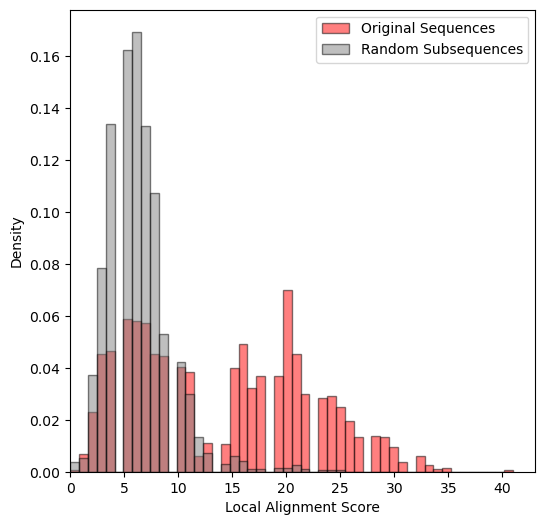

Original Sequences - Local Alignment Score:
count    1959.000000
mean       14.083716
std         8.081248
min         0.000000
25%         7.000000
50%        15.000000
75%        20.000000
max        41.000000
Name: Local_Alignment_Score, dtype: float64

Random Subsequences - Local Alignment Score:
count    1959.000000
mean        6.362430
std         2.948197
min         0.000000
25%         4.000000
50%         6.000000
75%         8.000000
max        25.000000
Name: Local_Alignment_Score, dtype: float64

Mann-Whitney U test p-value: 1.37e-200


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# File paths
file1 = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_sequence_signal_peptide_comparison_results.csv"
file2 = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/similarity_metrics_random_subsequences.csv"

# Read the files and extract Local_Alignment_Score
df1 = pd.read_csv(file1)
local_scores1 = df1['Local_Alignment_Score'].tolist()
df2 = pd.read_csv(file2)
local_scores2 = df2['Local_Alignment_Score'].tolist()

# Perform Mann-Whitney U test
statistic, p_value = stats.mannwhitneyu(local_scores1, local_scores2, alternative='two-sided')

# Determine the range for the bins
min_value = min(min(local_scores1), min(local_scores2))
max_value = max(max(local_scores1), max(local_scores2))

# Create a common set of bins
bins = np.linspace(min_value, max_value, 51)

# Create the plot
plt.figure(figsize=(6, 6))

# Plot histograms with common bins and black edges
plt.hist(local_scores1, bins=bins, alpha=0.5, label='Original Sequences', color='red', 
         weights=np.ones(len(local_scores1)) / len(local_scores1),
         edgecolor='black', linewidth=1)  # Added black edges
plt.hist(local_scores2, bins=bins, alpha=0.5, label='Random Subsequences', color='gray',
         weights=np.ones(len(local_scores2)) / len(local_scores2),
         edgecolor='black', linewidth=1)  # Added black edges

# Add labels
plt.xlabel('Local Alignment Score')
plt.ylabel('Density')
# After creating the plot but before plt.show()
plt.xlim(0, None)  # Start at 0, end at default value
plt.legend()

# Save as PDF with vector graphics preserved
plt.savefig("/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_Local_alignment_score_comparison.pdf", 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight',
            transparent=False)

plt.savefig("/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_Local_alignment_score_comparison.svg", 
            format='svg', 
            dpi=300, 
            bbox_inches='tight',
            transparent=False)

# Show the plot
plt.show()

# Print statistics and p-value
print("Original Sequences - Local Alignment Score:")
print(df1['Local_Alignment_Score'].describe())
print("\nRandom Subsequences - Local Alignment Score:")
print(df2['Local_Alignment_Score'].describe())
print(f"\nMann-Whitney U test p-value: {p_value:.2e}")

In [23]:
#find how many genes have motifs that signiicantly align to signal peptide:

motifs_df=pd.read_csv('/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_sequence_signal_peptide_comparison_results.csv')
signal_df=motifs_df[motifs_df['Local_Alignment_Score']>14]
print (signal_df.shape)
print (motifs_df.shape)

(994, 8)
(1959, 8)


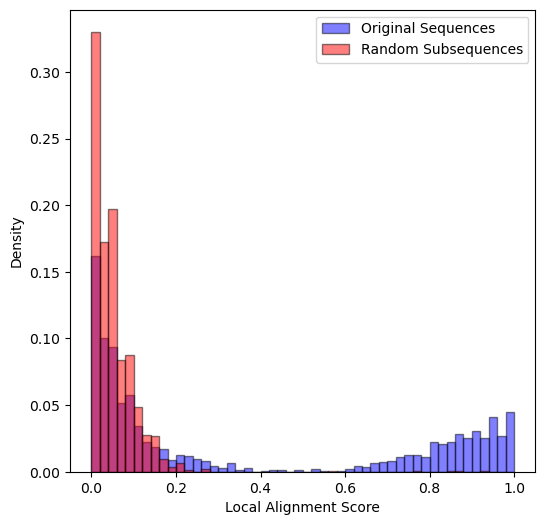

Original Sequences - Sequence Identity:
count    1959.000000
mean        0.370181
std         0.394101
min         0.000000
25%         0.037037
50%         0.120000
75%         0.833333
max         1.000000
Name: Sequence_Identity, dtype: float64

Random Subsequences - Sequence Identity:
count    1959.000000
mean        0.047674
std         0.059979
min         0.000000
25%         0.000000
50%         0.038462
75%         0.071429
max         0.925926
Name: Sequence_Identity, dtype: float64

Mann-Whitney U test p-value: 7.21e-151


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# File paths
file1 = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_sequence_signal_peptide_comparison_results.csv"
file2 = "/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/similarity_metrics_random_subsequences.csv"

# Read the files and extract Local_Alignment_Score
df1 = pd.read_csv(file1)
local_scores1 = df1['Sequence_Identity'].tolist()
df2 = pd.read_csv(file2)
local_scores2 = df2['Sequence_Identity'].tolist()

# Perform Mann-Whitney U test
statistic, p_value = stats.mannwhitneyu(local_scores1, local_scores2, alternative='two-sided')

# Determine the range for the bins
min_value = min(min(local_scores1), min(local_scores2))
max_value = max(max(local_scores1), max(local_scores2))

# Create a common set of bins
bins = np.linspace(min_value, max_value, 51)

# Create the plot
plt.figure(figsize=(6, 6))

# Plot histograms with common bins and black edges
plt.hist(local_scores1, bins=bins, alpha=0.5, label='Original Sequences', color='blue', 
         weights=np.ones(len(local_scores1)) / len(local_scores1),
         edgecolor='black', linewidth=1)  # Added black edges
plt.hist(local_scores2, bins=bins, alpha=0.5, label='Random Subsequences', color='red',
         weights=np.ones(len(local_scores2)) / len(local_scores2),
         edgecolor='black', linewidth=1)  # Added black edges

# Add labels
plt.xlabel('Local Alignment Score')
plt.ylabel('Density')
plt.legend()

# Save as PDF with vector graphics preserved
plt.savefig("/tscc/nfs/home/yumei/Documents/nlp_mRNA/hotspot_analysis/human_sequence_identity_score_comparison.pdf", 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight',
            transparent=True)

# Show the plot
plt.show()

# Print statistics and p-value
print("Original Sequences - Sequence Identity:")
print(df1['Sequence_Identity'].describe())
print("\nRandom Subsequences - Sequence Identity:")
print(df2['Sequence_Identity'].describe())
print(f"\nMann-Whitney U test p-value: {p_value:.2e}")